<a href="https://colab.research.google.com/github/ShiningYang0207/ECE661_final_project/blob/main/i_to_i_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ln -s '/content/drive/MyDrive/ECE 661/ECE 661 final project/robustness_applications/' /content/robustness_applications

ln: failed to create symbolic link '/content/robustness_applications': File exists


In [ ]:
!pip install cox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.insert(0,'/content/robustness_applications/')

In [ ]:
%cd drive/MyDrive/ECE\ 661\ final\ project/robustness_applications/

/content/drive/.shortcut-targets-by-id/1s7c6Z5jJyUtimJ5tJntlT762pMW9e0xT/ECE 661 final project/robustness_applications


In [ ]:
!pip install -r "/content/drive/MyDrive/ECE 661 final project/robustness_applications/requirements.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
import attacks_hw5
#from fastai.vision.all import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
# more libraries
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import tensorflow as tf

In [ ]:
device = "cuda" if ch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [ ]:
DATA = 'ImageNet' # Choices: ['RestrictedImageNet']
BATCH_SIZE = 1
NUM_WORKERS = 8
SR_FACTOR_RIN = 8

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1

In [ ]:
# from robustness.datasets import A2B
# dataset = A2B('/content/drive/MyDrive/ECE 661/ECE 661 final project/robustness_applications/dataset/')

In [ ]:
# Load dataset
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_dataset = ImageFolder(root="dataset/val", transform=transform)

In [ ]:
# making test loader

test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
            shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
data_iterator = enumerate(test_loader)

In [ ]:
# initialize ResNet50
model = torchvision.models.resnet50()
checkpoint = ch.load('models/ImageNet.pt')

In [ ]:
import re
modelWeights = {}
for k,v in checkpoint['model'].items():
  if re.match("module\.model[a-z0-9.]*", k):
    newKey = k.split("module.model.")[1]
    modelWeights[newKey] = v

In [ ]:
print(set(modelWeights.keys()).difference(set(model.state_dict().keys())))

set()


In [ ]:
model.load_state_dict(modelWeights)

<All keys matched successfully>

In [ ]:
model.eval()
print('done')

done


### Pair 1

In [ ]:
targetPairs = [2,5]
im_test = []
targ_test = []
orig_test = []
while len(targ_test) < 8:
  _, (img_rin, targ_rin) = next(enumerate(test_loader))
  if targ_rin.numpy()[0] in targetPairs:
    im_test.append(img_rin)
    orig_test.append(targ_rin)
    if targ_rin.numpy()[0] == targetPairs[0]:
      targ_test.append(ch.tensor(targetPairs[1]))
    else:
      targ_test.append(ch.tensor(targetPairs[0]))
    print(targ_test)
img = ch.cat(im_test)
targ = ch.stack(targ_test)
targ_original = ch.cat(orig_test)

[tensor(5)]
[tensor(5), tensor(5)]
[tensor(5), tensor(5), tensor(2)]
[tensor(5), tensor(5), tensor(2), tensor(2)]
[tensor(5), tensor(5), tensor(2), tensor(2), tensor(2)]
[tensor(5), tensor(5), tensor(2), tensor(2), tensor(2), tensor(5)]
[tensor(5), tensor(5), tensor(2), tensor(2), tensor(2), tensor(5), tensor(2)]
[tensor(5), tensor(5), tensor(2), tensor(2), tensor(2), tensor(5), tensor(2), tensor(2)]


In [ ]:
targ_original

tensor([2, 2, 5, 5, 5, 2, 5, 5])

In [ ]:
# Remap Labels
label_mapping = {
    -1 : -1,
    0 : 0,
    1 : 217,
    2 : 482,
    3 : 491,
    4 : 497,
    5 : 566,
    6 : 569,
    7 : 571,
    8 : 574,
    9 : 701,

}
targ = targ.numpy()
for i in range(0, len(targ)):
  targ[i] = label_mapping[targ[i]]
targ = ch.tensor(targ)
targ

tensor([566, 566, 482, 482, 482, 566, 482, 482])

In [ ]:
targ_original = targ_original.numpy()
for i in range(0, len(targ_original)):
  targ_original[i] = label_mapping[targ_original[i]]
targ_original = ch.tensor(targ_original)

In [ ]:
targ_original

tensor([482, 482, 566, 566, 566, 482, 566, 566])

In [ ]:
# PGD parameters
kwargs = {
        #'criterion': ch.nn.CrossEntropyLoss(reduction='none'),
        'constraint':'2',
        'eps': 80,
        'step_size': 0.5,
        'iterations': 200,
        'do_tqdm': True,
        'targeted': True,
}

In [ ]:
from robustness.tools.helpers import InputNormalize
import scipy
class ModelWithNormalizer(ch.nn.Module):
    def __init__(self, m, n):
      super(ModelWithNormalizer, self).__init__()
      self.model= m
      self.normalizer = n
    
    def forward(self, x):
      return self.model(self.normalizer(x).float())
mean = ch.tensor(scipy.ndimage.mean(img.numpy())).double()
std = ch.tensor(scipy.ndimage.standard_deviation(img.numpy())).double()
normalizedModel = ModelWithNormalizer(model, InputNormalize(mean,std))

In [ ]:
sys.path.insert(0, '/content/drive/MyDrive/ECE 661 final project/robustness_applications')
import attacks_super_resolution as attacks
EPS= kwargs['eps']
ITS=kwargs['iterations']
ALPHA = kwargs['step_size']
img_translated = attacks.FGM_L2_attack(normalizedModel.to(device), device, img.to(device), targ.to(device), ALPHA, ITS)

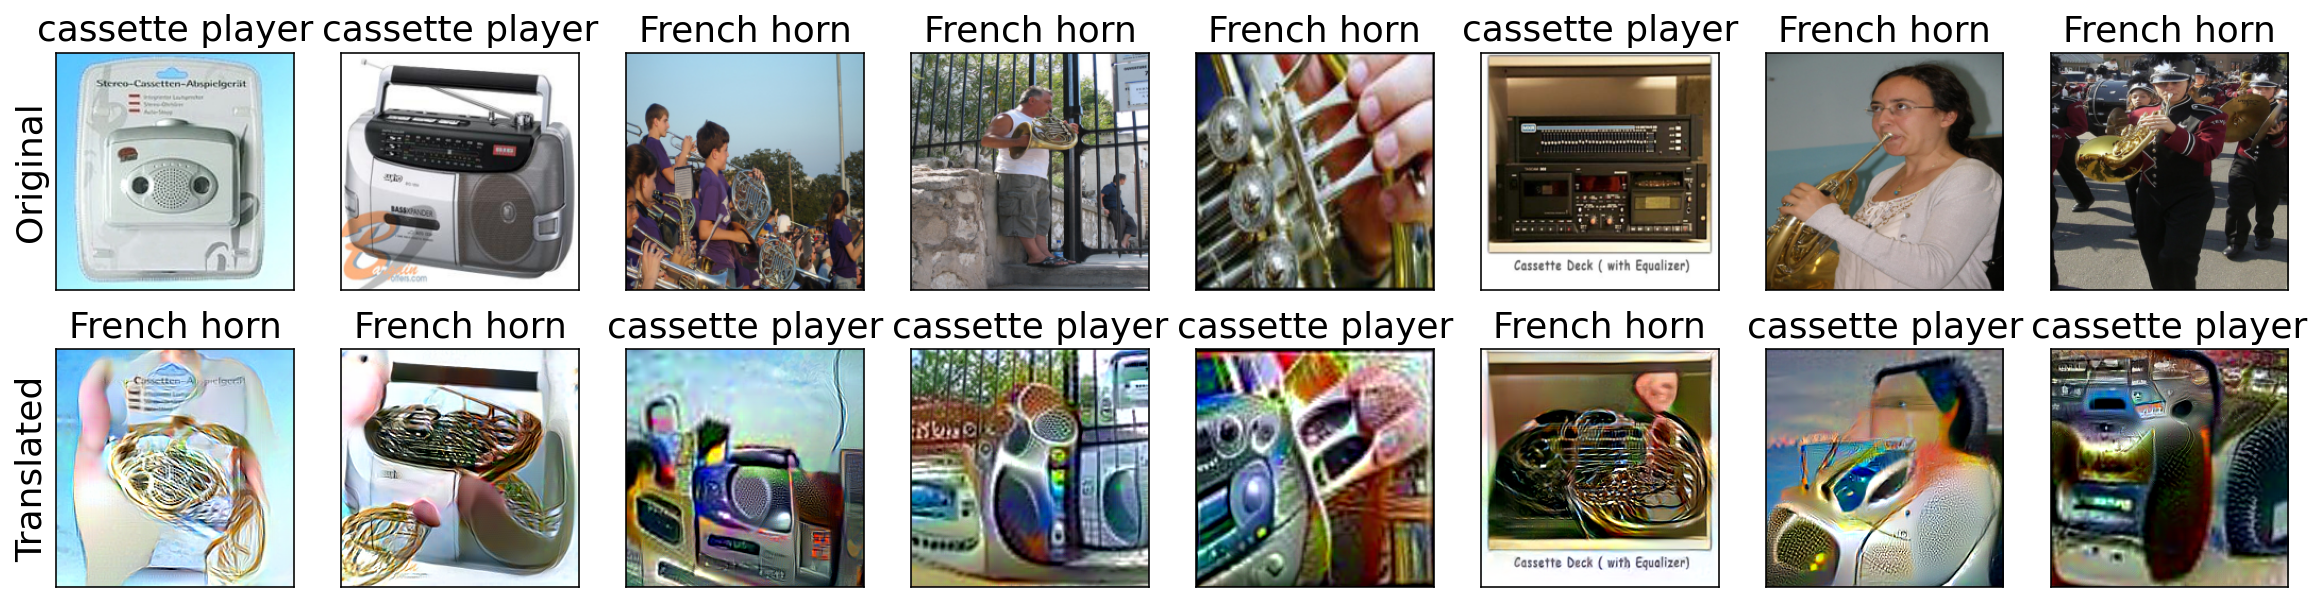

In [ ]:
# Visualize image-to-image translation
show_image_row([img.cpu(), img_translated.detach().cpu()], ["Original", "Translated"], 
               tlist=[[CLASSES[int(t)] for t in targ_original],
                    [CLASSES[int(t)] for t in targ]],
               fontsize=18)

### Pair 2

In [ ]:
targetPairs = [4,7]
im_test = []
targ_test = []
orig_test = []
while len(targ_test) < 8:
  _, (img_rin, targ_rin) = next(enumerate(test_loader))
  if targ_rin.numpy()[0] in targetPairs:
    im_test.append(img_rin)
    orig_test.append(targ_rin)
    if targ_rin.numpy()[0] == targetPairs[0]:
      targ_test.append(ch.tensor(targetPairs[1]))
    else:
      targ_test.append(ch.tensor(targetPairs[0]))
    print(targ_test)
img = ch.cat(im_test)
targ = ch.stack(targ_test)
targ_original = ch.cat(orig_test)

[tensor(7)]
[tensor(7), tensor(7)]
[tensor(7), tensor(7), tensor(4)]
[tensor(7), tensor(7), tensor(4), tensor(4)]
[tensor(7), tensor(7), tensor(4), tensor(4), tensor(7)]
[tensor(7), tensor(7), tensor(4), tensor(4), tensor(7), tensor(4)]
[tensor(7), tensor(7), tensor(4), tensor(4), tensor(7), tensor(4), tensor(4)]
[tensor(7), tensor(7), tensor(4), tensor(4), tensor(7), tensor(4), tensor(4), tensor(7)]


In [ ]:
targ_original

tensor([4, 4, 7, 7, 4, 7, 7, 4])

In [ ]:
# Remap Labels
label_mapping = {
    -1 : -1,
    0 : 0,
    1 : 217,
    2 : 482,
    3 : 491,
    4 : 497,
    5 : 566,
    6 : 569,
    7 : 571,
    8 : 574,
    9 : 701,

}
targ = targ.numpy()
for i in range(0, len(targ)):
  targ[i] = label_mapping[targ[i]]
targ = ch.tensor(targ)
targ

tensor([571, 571, 497, 497, 571, 497, 497, 571])

In [ ]:
for t in label_mapping.values():
  print(CLASSES[int(t)])

noise
tench
English springer
cassette player
chainsaw
church
French horn
garbage truck
gas pump
golf ball
parachute


In [ ]:
targ_original = targ_original.numpy()
for i in range(0, len(targ_original)):
  targ_original[i] = label_mapping[targ_original[i]]
targ_original = ch.tensor(targ_original)

In [ ]:
targ_original

tensor([497, 497, 571, 571, 497, 571, 571, 497])

In [ ]:
# PGD parameters
kwargs = {
        #'criterion': ch.nn.CrossEntropyLoss(reduction='none'),
        'constraint':'2',
        'eps': 80,
        'step_size': 0.5,
        'iterations': 200,
        'do_tqdm': True,
        'targeted': True,
}

In [ ]:
from robustness.tools.helpers import InputNormalize
import scipy
class ModelWithNormalizer(ch.nn.Module):
    def __init__(self, m, n):
      super(ModelWithNormalizer, self).__init__()
      self.model= m
      self.normalizer = n
    
    def forward(self, x):
      return self.model(self.normalizer(x).float())
mean = ch.tensor(scipy.ndimage.mean(img.numpy())).double()
std = ch.tensor(scipy.ndimage.standard_deviation(img.numpy())).double()
normalizedModel = ModelWithNormalizer(model, InputNormalize(mean,std))

In [ ]:
sys.path.insert(0, '/content/drive/MyDrive/ECE 661 final project/robustness_applications')
import attacks_super_resolution as attacks
EPS= kwargs['eps']
ITS=kwargs['iterations']
ALPHA = kwargs['step_size']
img_translated = attacks.FGM_L2_attack(normalizedModel.to(device), device, img.to(device), targ.to(device), ALPHA, ITS)

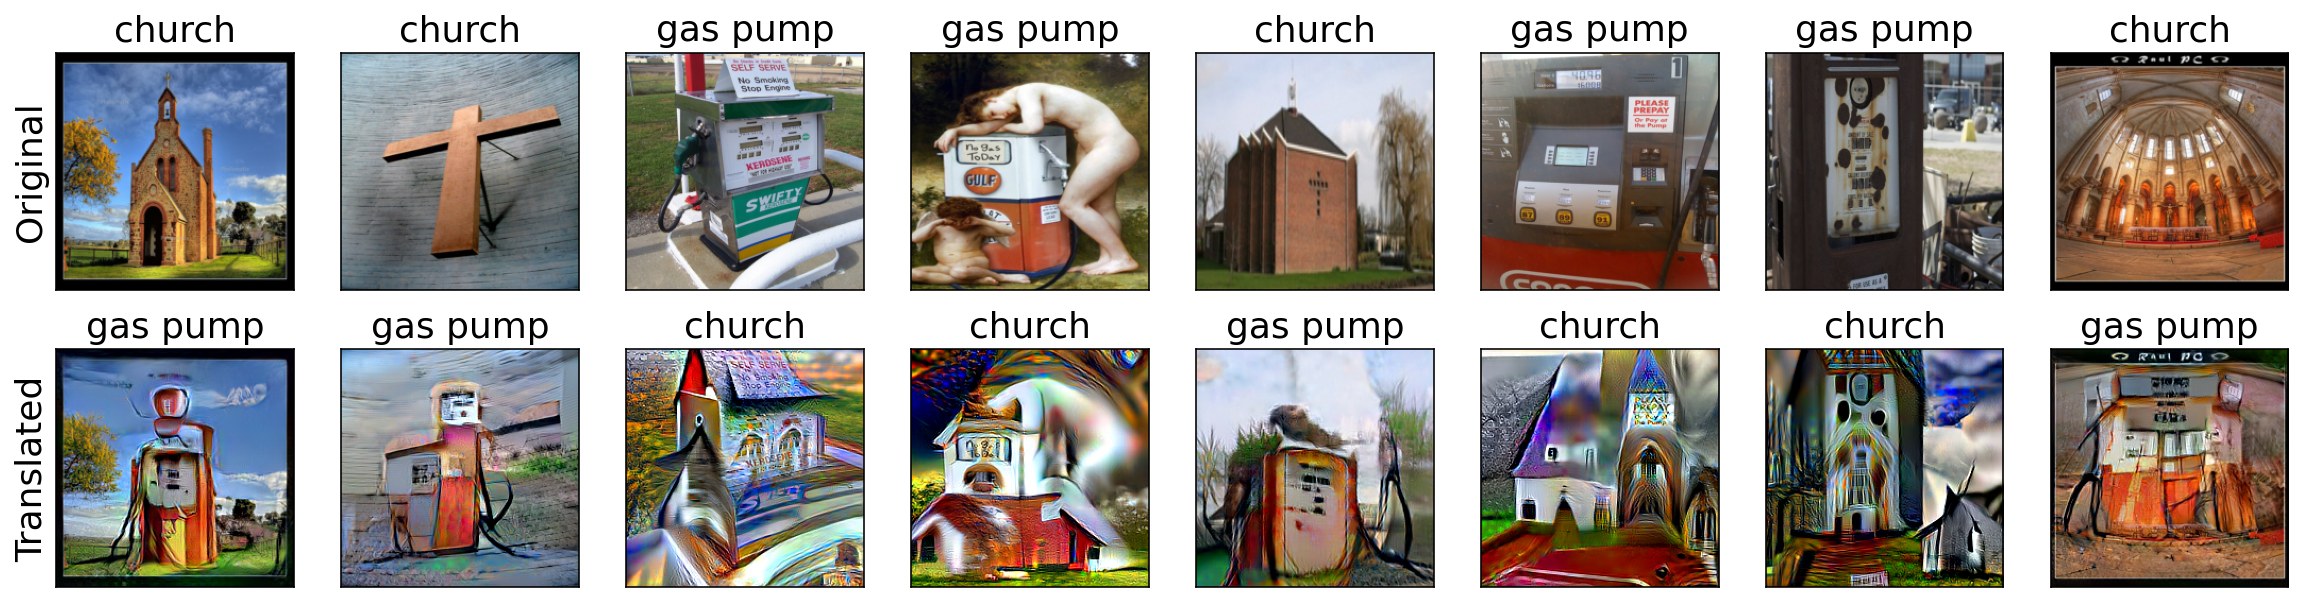

In [ ]:
# Visualize image-to-image translation
show_image_row([img.cpu(), img_translated.detach().cpu()], ["Original", "Translated"], 
               tlist=[[CLASSES[int(t)] for t in targ_original],
                    [CLASSES[int(t)] for t in targ]],
               fontsize=18)

### Pair 3

In [ ]:
targetPairs = [6,8]
im_test = []
targ_test = []
orig_test = []
while len(targ_test) < 8:
  _, (img_rin, targ_rin) = next(enumerate(test_loader))
  if targ_rin.numpy()[0] in targetPairs:
    im_test.append(img_rin)
    orig_test.append(targ_rin)
    if targ_rin.numpy()[0] == targetPairs[0]:
      targ_test.append(ch.tensor(targetPairs[1]))
    else:
      targ_test.append(ch.tensor(targetPairs[0]))
    print(targ_test)
img = ch.cat(im_test)
targ = ch.stack(targ_test)
targ_original = ch.cat(orig_test)

[tensor(8)]
[tensor(8), tensor(6)]
[tensor(8), tensor(6), tensor(6)]
[tensor(8), tensor(6), tensor(6), tensor(8)]
[tensor(8), tensor(6), tensor(6), tensor(8), tensor(8)]
[tensor(8), tensor(6), tensor(6), tensor(8), tensor(8), tensor(8)]
[tensor(8), tensor(6), tensor(6), tensor(8), tensor(8), tensor(8), tensor(8)]
[tensor(8), tensor(6), tensor(6), tensor(8), tensor(8), tensor(8), tensor(8), tensor(6)]


In [ ]:
targ_original

tensor([6, 8, 8, 6, 6, 6, 6, 8])

In [ ]:
# Remap Labels
label_mapping = {
    -1 : -1,
    0 : 0,
    1 : 217,
    2 : 482,
    3 : 491,
    4 : 497,
    5 : 566,
    6 : 569,
    7 : 571,
    8 : 574,
    9 : 701,

}
targ = targ.numpy()
for i in range(0, len(targ)):
  targ[i] = label_mapping[targ[i]]
targ = ch.tensor(targ)
targ

tensor([574, 569, 569, 574, 574, 574, 574, 569])

In [ ]:
targ_original = targ_original.numpy()
for i in range(0, len(targ_original)):
  targ_original[i] = label_mapping[targ_original[i]]
targ_original = ch.tensor(targ_original)

In [ ]:
targ_original

tensor([569, 574, 574, 569, 569, 569, 569, 574])

In [ ]:
# PGD parameters
kwargs = {
        #'criterion': ch.nn.CrossEntropyLoss(reduction='none'),
        'constraint':'2',
        'eps': 80,
        'step_size': 0.5,
        'iterations': 200,
        'do_tqdm': True,
        'targeted': True,
}

In [ ]:
from robustness.tools.helpers import InputNormalize
import scipy
class ModelWithNormalizer(ch.nn.Module):
    def __init__(self, m, n):
      super(ModelWithNormalizer, self).__init__()
      self.model= m
      self.normalizer = n
    
    def forward(self, x):
      return self.model(self.normalizer(x).float())
mean = ch.tensor(scipy.ndimage.mean(img.numpy())).double()
std = ch.tensor(scipy.ndimage.standard_deviation(img.numpy())).double()
normalizedModel = ModelWithNormalizer(model, InputNormalize(mean,std))

In [ ]:
sys.path.insert(0, '/content/drive/MyDrive/ECE 661 final project/robustness_applications')
import attacks_super_resolution as attacks
EPS= kwargs['eps']
ITS=kwargs['iterations']
ALPHA = kwargs['step_size']
img_translated = attacks.FGM_L2_attack(normalizedModel.to(device), device, img.to(device), targ.to(device), ALPHA, ITS)

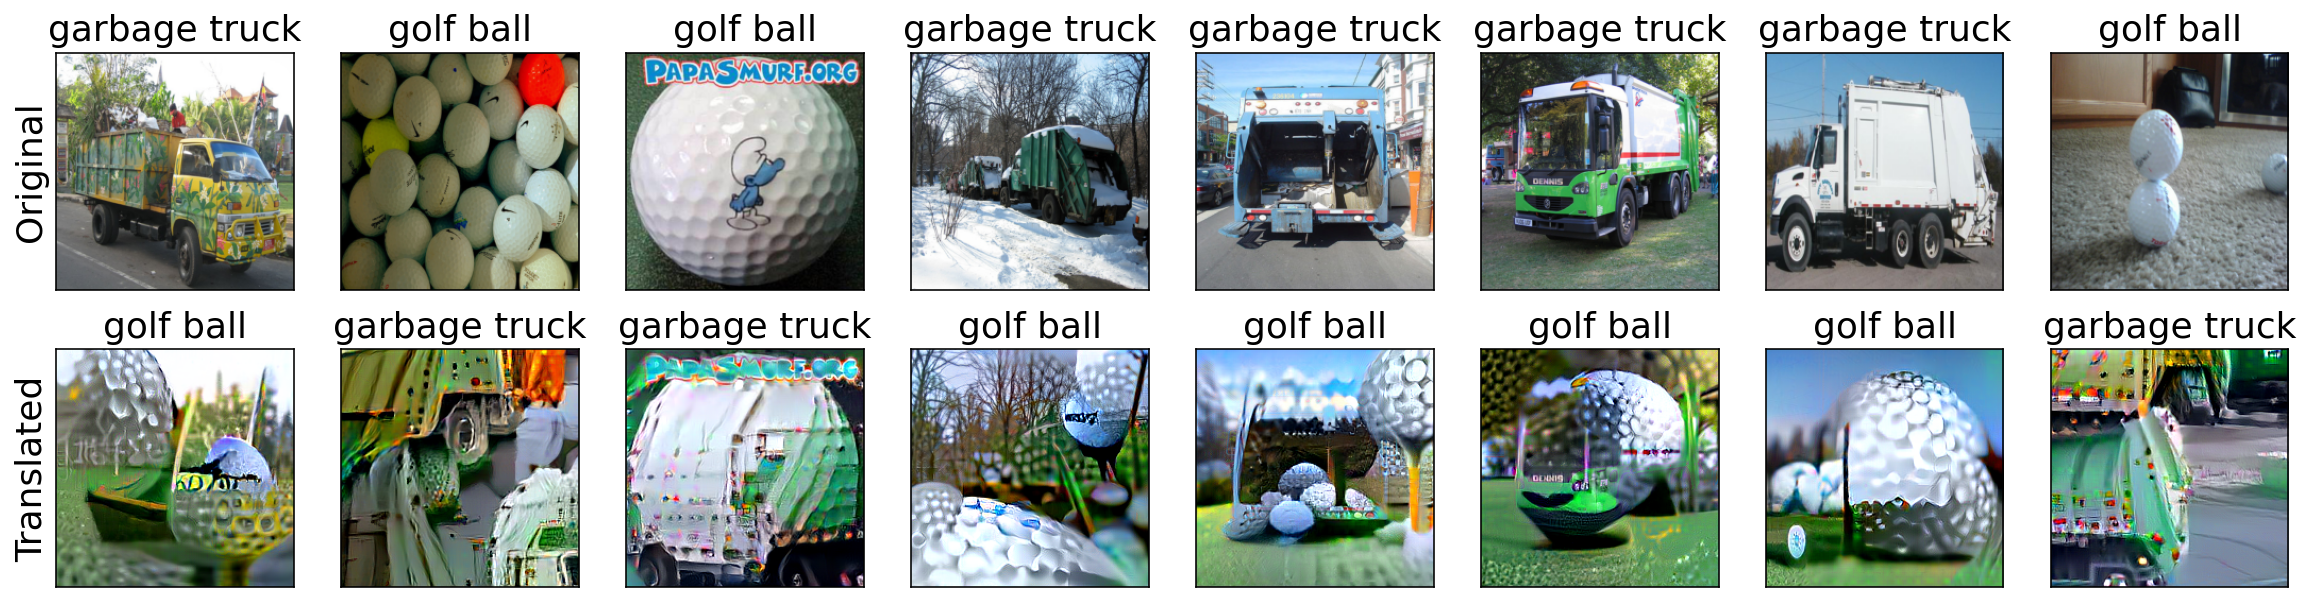

In [ ]:
# Visualize image-to-image translation
show_image_row([img.cpu(), img_translated.detach().cpu()], ["Original", "Translated"], 
               tlist=[[CLASSES[int(t)] for t in targ_original],
                    [CLASSES[int(t)] for t in targ]],
               fontsize=18)